# Fast Iterative Solvers - Project 2

Name: Sebastian Bennet Linden<br>
Matriculation Number: 409559

In [1]:
from msr_reader import msr_reader
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from math import sqrt

# Paths
directory = os.getcwd()
# Read matrices
A = msr_reader(f"{directory}/project2_spd_matrix.txt")
B = msr_reader(f"{directory}/project_1_matrices/cg_matrix_msr_1.txt")
C = msr_reader(f"{directory}/project_1_matrices/cg_matrix_msr_2.txt")
print(A.shape[0])
print(B.shape[0])
print(C.shape[0])

2439
2073
5364


# Introduction

This report documents the performance of two different approaches to find the largest eigenvalue of the matrices
- $A\in \mathbb R^{2439\times 2439}$ (`project2_spd_matrix.txt`)
- $B\in \mathbb R^{2073\times 2073}$ (`cg_matrix_msr_1.txt`)
- $C\in \mathbb R^{5364\times 5364}$ (`cg_matrix_msr_2.txt`)

Since all matrices are large, their eigenvalues cannot be determined exactly by solving the characteristic polynomial $det(A-\lambda I)=0$. 

In the first approach the power iteration algorithm is applied. While it will not be explained how works, it can be said, that it only returns the largest eigenvalue of a system, not all eigenvalues. While the true largest eigenvalue is unknown, the absolute difference between $\lambda^{(k)}$ and $\lambda^{(k+1)}$ from iteration $k$ to iteration $k+1$ is used as the stopping criteria: $|\lambda^{(k+1)}-\lambda^{(k)}|<tol$. 

It is possible to construct an upper Hessenberg matrix $H_m$ from all three above mentioned matrices using the Lanczos method. If the original matrix is symmetric, then $H_m$ is a symmetric tridiagonal matrix. Furthermore, $H_m$ has approximately the same eigenvalues as the original matrix. This can be exploited by applying the power iteration algorithm to $H_m$ instead. This promisses a significant improvement of the convergence rate. The following tests show the significant performance improvement, that can be gained.

# Pure Power Iterations

In this first test, the matrix `project2_spd_matrix.txt` is used. It is SPD and of the size $\mathbb R^{2439\times 2439}$. The initial guess for the dominant eigenvector is set to $q=\frac{1}{\sqrt n}(1, 1, \dots, 1)^T$ and the convergence tolerance is set to $10^{-8}$.

In [2]:
def power_iterations(A, tol=1e-8, max_iter=1000):
    N = A.shape[0]
    q = np.ones(N) / np.sqrt(N)
    iterations = 0
    lambdas = []
    improvements = []
    times = []
    start_time = time.time()
    while True:
        iterations += 1
        # Core Algorithm
        z = A.dot(q)
        q = z / np.linalg.norm(z)
        l = q.conj().T.dot(A.dot(q))
        # Additional code
        lambdas.append(l)
        if iterations > 1:
            improvement = abs(l - lambdas[-2])
            improvements.append(improvement)
            if improvement < tol:
                break
        end_time = time.time()
        times.append(end_time - start_time)
        if iterations >= max_iter:
            print("Maximum iterations reached without convergence.")
            break

    end_time = time.time()
    times.append(end_time - start_time)
    return l, iterations, improvements, times

# Perform Test
lambda_max, iterations, improvements, times = power_iterations(A, tol=1e-8)
print(f"It took {len(improvements)} iterations until convergence.")
print(f"The largest eigenvalue is {lambda_max}.")
print(f"This took {round(times[-1], 3)} seconds.")

It took 115 iterations until convergence.
The largest eigenvalue is 94759580.76483318.
This took 0.324 seconds.


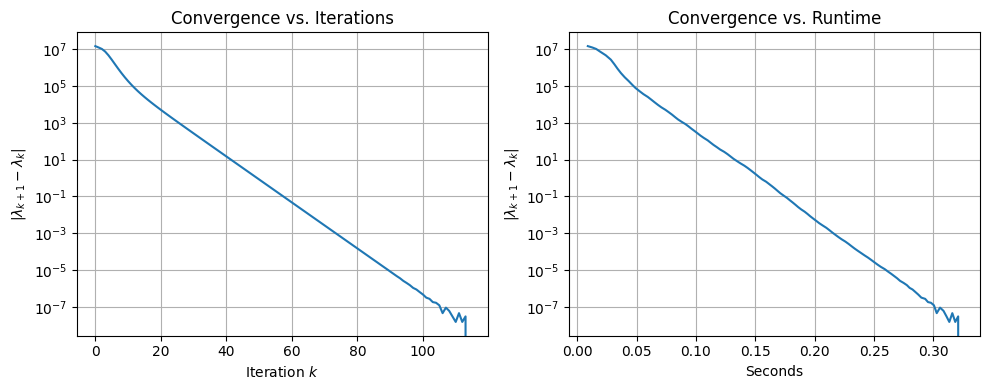

In [3]:
I = range(iterations - 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot: Iteration vs improvement
axs[0].plot(I, improvements)
axs[0].set_yscale("log")
axs[0].set_xlabel(r"Iteration $k$")
axs[0].set_ylabel(r"$|\lambda_{k+1}-\lambda_k|$")
axs[0].grid(True)
axs[0].set_title("Convergence vs. Iterations")

# Second plot: Time vs improvement
axs[1].plot(times[1:], improvements)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"Seconds")
axs[1].set_ylabel(r"$|\lambda_{k+1}-\lambda_k|$")
axs[1].grid(True)
axs[1].set_title("Convergence vs. Runtime")

plt.tight_layout()
plt.show()


# Application of Lanczos Reduction

In the second test, the matrices $B$ and $C$ are first reduced to a symmetric tridiagonal matrix $H_m$ using the Lanczos method with Krylov subspace dimensions $m=30$, $50$, $75$, and $100$. As before, the initial vector is set to $q = \frac{1}{\sqrt n}(1, 1, \dots, 1)^T$.

The power iteration is then applied to each $H_m$ with the convergence tolerances depending on $m$: $10^{-2}$, $10^{-4}$, $10^{-6}$, and $10^{-10}$ respectively. For comparison, the pure power iteration is also repeated on the full matrix $A$ using the same tolerances.

For each case, the convergence of the eigenvalue approximation is evaluated in terms of iteration count and runtime, allowing a direct performance comparison between the original and the reduced systems.


In [16]:
def lanczos(A, v0, m):
    n = v0.shape[0]
    V = np.zeros((n, m))
    alpha = np.zeros(m)
    beta = np.zeros(m - 1)

    v_prev = np.zeros(n)
    v = v0 / np.linalg.norm(v0)

    for j in range(m):
        V[:, j] = v
        w = A @ v                       # Generate the next Krylov-vector
        if j > 0:
            w -= beta[j - 1] * v_prev   # Orthogonalization step (1)
        alpha[j] = np.dot(v, w)         # Estimate the j-th eigenvalue
        w -= alpha[j] * v               # Orthogonalization step (2)
        if j < m - 1:
            beta[j] = np.linalg.norm(w)
            if beta[j] < 1e-14:
                return alpha[:j + 1], beta[:j], V[:, :j + 1]
            v_prev = v
            v = w / beta[j]             # Normalize the vector for the next iteration
    return alpha, beta, V


In [17]:
def construct_tridiagonal_matrix(alpha, beta):
    m = len(alpha)
    T = np.zeros((m, m))
    for i in range(m):
        T[i, i] = alpha[i]
        if i < m - 1:
            T[i, i+1] = beta[i]
            T[i+1, i] = beta[i]
    return T

Matrix: `cg_matrix_msr_1.txt`

In [18]:
# Preparation
N = B.shape[0]
v0 = (1/sqrt(N)) * np.ones(N)
m = 100
alpha, beta, V = lanczos(B, v0, m)
H = construct_tridiagonal_matrix(alpha, beta)
l, iterations, improvements, times = power_iterations(H, tol=1e-12, max_iter=1000)
print(l)

159710384.44264638


### Test Setup
Test the following 4 szenarios:
- $m=30, 50, 75, 100$
- $tol=10^{-2}, 10^{-4}, 10^{-6}, 10^{-10}$

For each szenario the Lanczos algorithm was iterated $m$-times and then power iterations were applied until the stopping criteria $|\lambda_{k+1}-\lambda_k|< tol$ is met. Finally, we're comparing with and without Lanczos method

In [20]:
lanczos_iterations = [30, 50, 75, 100]
tolerances = [1e-2, 1e-4, 1e-6, 1e-10]
test_data = []

for use_lanczos in [True, False]:
    # Setup
    N = B.shape[0]
    v0 = (1/sqrt(N)) * np.ones(N)
    for m, tol in zip(lanczos_iterations, tolerances):
        # Testing
        if use_lanczos:
            alpha, beta, V = lanczos(B, v0, m)
            H = construct_tridiagonal_matrix(alpha, beta)
            l, iterations, improvements, times = power_iterations(H, tol=tol, max_iter=500)
        else: 
            l, iterations, improvements, times = power_iterations(B, tol=tol, max_iter=500)
        results = {
            "m": m,
            "iterations": iterations,
            "improvements": improvements,
            "times": times
        }
        test_data.append(results)
for data in test_data:
    print(data["m"])

30
50
75
100
30
50
75
100


Convergence Plot

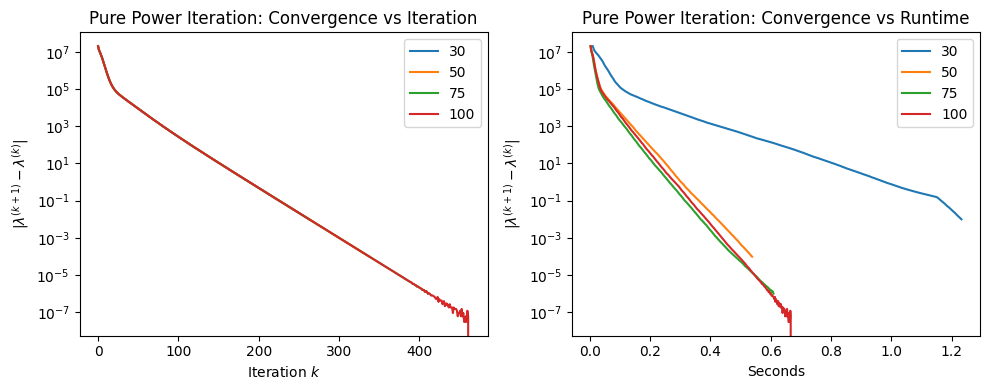

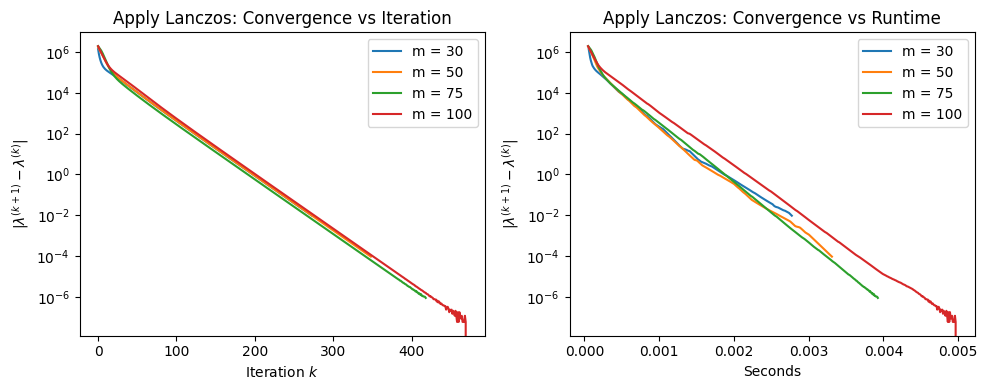

In [25]:
# Separate the data for plotting
lanczos_data = test_data[:4]  # even indices: Lanczos-based
pure_data = test_data[4:]     # odd indices: pure power iteration

# --- Figure 1: Pure Power Iteration ---
fig1, axs1 = plt.subplots(1, 2, figsize=(10, 4))

for result in pure_data:
    label = result["m"]
    axs1[0].plot(range(result["iterations"] - 1), result["improvements"], label=label)
    axs1[1].plot(result["times"][1:], result["improvements"], label=label)

# Configure subplots for Figure 1
axs1[0].set_yscale("log")
axs1[0].set_xlabel(r"Iteration $k$")
axs1[0].set_ylabel(r"$|\lambda^{(k+1)} - \lambda^{(k)}|$")
axs1[0].set_title("Pure Power Iteration: Convergence vs Iteration")
axs1[0].legend()

axs1[1].set_yscale("log")
axs1[1].set_xlabel(r"Seconds")
axs1[1].set_ylabel(r"$|\lambda^{(k+1)} - \lambda^{(k)}|$")
axs1[1].set_title("Pure Power Iteration: Convergence vs Runtime")
axs1[1].legend()

plt.tight_layout()
plt.show()

# --- Figure 2: Lanczos + Power Iteration ---
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 4))

for result in lanczos_data:
    label = f"m = {result['m']}"
    axs2[0].plot(range(result["iterations"] - 1), result["improvements"], label=label)
    axs2[1].plot(result["times"][1:], result["improvements"], label=label)

# Configure subplots for Figure 2
axs2[0].set_yscale("log")
axs2[0].set_xlabel(r"Iteration $k$")
axs2[0].set_ylabel(r"$|\lambda^{(k+1)} - \lambda^{(k)}|$")
axs2[0].set_title("Apply Lanczos: Convergence vs Iteration")
axs2[0].legend()

axs2[1].set_yscale("log")
axs2[1].set_xlabel(r"Seconds")
axs2[1].set_ylabel(r"$|\lambda^{(k+1)} - \lambda^{(k)}|$")
axs2[1].set_title("Apply Lanczos: Convergence vs Runtime")
axs2[1].legend()

plt.tight_layout()
plt.show()

In [33]:
for result in test_data:
    m = result["m"]
    its = result["iterations"]
    dur = round(result["times"][-1], 4)
    print(f"m: {m} \tIterations: {its}  Duration: {dur}")

m: 30 	Iterations: 275  Duration: 0.0028
m: 50 	Iterations: 350  Duration: 0.0033
m: 75 	Iterations: 420  Duration: 0.0039
m: 100 	Iterations: 472  Duration: 0.005
m: 30 	Iterations: 265  Duration: 1.2321
m: 50 	Iterations: 340  Duration: 0.5384
m: 75 	Iterations: 413  Duration: 0.6092
m: 100 	Iterations: 464  Duration: 0.6676


### Power Iteration Results (Lanczos on Tridiagonal Matrix)

| Krylov Dim. \(m\) | Iterations | Duration (s) |
|-------------------|------------|--------------|
| 30                | 275        | 0.0028       |
| 50                | 350        | 0.0033       |
| 75                | 420        | 0.0039       |
| 100               | 472        | 0.0050       |

### Power Iteration Results (Pure on Original Matrix)

| Krylov Dim. \(m\) | Iterations | Duration (s) |
|-------------------|------------|--------------|
| 30                | 265        | 1.2321       |
| 50                | 340        | 0.5384       |
| 75                | 413        | 0.6092       |
| 100               | 464        | 0.6676       |
